In [1]:
!pip install autocorrect
!pip install transformers==3.0.0

     |████████████████████████████████| 624kB 16.1MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.3.0-cp36-none-any.whl size=621588 sha256=a2b9a34e5cc685684e252a36725fdce62078f62aced21f7011604a3ca3431d7d
  Stored in directory: /root/.cache/pip/wheels/cc/1c/30/6b0199afbd20eef5959f5eaa0ead86aeef84391740482b2279
Successfully built autocorrect
     |████████████████████████████████| 757kB 22.7MB/s 
     |████████████████████████████████| 1.2MB 55.9MB/s 
     |████████████████████████████████| 890kB 56.5MB/s 
     |████████████████████████████████| 3.0MB 52.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0c0d7286e54b6dad8cff3e2bf166007942c0b2056c9152beb54641119b155de6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import sys
sys.path.append('../')

In [1]:
from utils.preprocess import Preprocess
from utils.utils import Utils
from modules.mtlm import MTLM
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf 

print("Tensorflow version: ",tf__version__)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [4]:
%%time
utils = Utils()
pre = Preprocess(mode="clean")

CPU times: user 3.42 s, sys: 135 ms, total: 3.56 s
Wall time: 3.56 s


In [5]:
data = utils.read_data("/content/gdrive/My Drive/WASSA-2021-Shared-Task/dataset/track-1-essay-empathy-train-normalized.csv")
data

,message_id,response_id,empathy,distress,empathy_bin,distress_bin,emotion_label,essay,gender,education,race,age,income,personality_conscientiousness,personality_openess,personality_extraversion,personality_agreeableness,personality_stability,iri_perspective_taking,iri_personal_distress,iri_fantasy,iri_empathatic_concern
0,R_1hGrPtWM4SumG0U_1,R_1hGrPtWM4SumG0U,5.667,4.375,1,1,sadness,it is really disheartening to read about thes...,1,4,1,33,50000,6.0,5.0,5.0,5.5,5.5,3.571,2.000,3.429,4.000
1,R_1hGrPtWM4SumG0U_2,R_1hGrPtWM4SumG0U,4.833,4.875,1,1,joy,the phone lines from the suicide prevention l...,1,4,1,33,50000,6.0,5.0,5.0,5.5,5.5,3.571,2.000,3.429,4.000
2,R_1hGrPtWM4SumG0U_3,R_1hGrPtWM4SumG0U,5.333,3.500,1,0,neutral,"no matter what your heritage , you should be ...",1,4,1,33,50000,6.0,5.0,5.0,5.5,5.5,3.571,2.000,3.429,4.000
3,R_1hGrPtWM4SumG0U_4,R_1hGrPtWM4SumG0U,4.167,5.250,1,1,fear,it is frightening to learn about all these sh...,1,4,1,33,50000,6.0,5.0,5.0,5.5,5.5,3.571,2.000,3.429,4.000
4,R_1hGrPtWM4SumG0U_5,R_1hGrPtWM4SumG0U,5.333,4.625,1,1,neutral,the eldest generation of russians are not bei...,1,4,1,33,50000,6.0,5.0,5.0,5.5,5.5,3.571,2.000,3.429,4.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,R_DHy2Rcz9Hym8jgl_1,R_DHy2Rcz9Hym8jgl,1.000,1.000,0,0,joy,"These days , women are winning in sports . Th...",2,4,3,34,30000,7.0,7.0,7.0,7.0,7.0,5.000,1.286,4.286,4.429
1856,R_DHy2Rcz9Hym8jgl_2,R_DHy2Rcz9Hym8jgl,1.000,1.000,0,0,anger,I hate SIS . They are a group full of hate an...,2,4,3,34,30000,7.0,7.0,7.0,7.0,7.0,5.000,1.286,4.286,4.429
1857,R_DHy2Rcz9Hym8jgl_3,R_DHy2Rcz9Hym8jgl,1.000,1.000,0,0,disgust,This is just disgusting . I cannot believe th...,2,4,3,34,30000,7.0,7.0,7.0,7.0,7.0,5.000,1.286,4.286,4.429
1858,R_DHy2Rcz9Hym8jgl_4,R_DHy2Rcz9Hym8jgl,1.000,1.000,0,0,surprise,I feel like the world is so corrupt that it n...,2,4,3,34,30000,7.0,7.0,7.0,7.0,7.0,5.000,1.286,4.286,4.429


In [6]:
%%time
train_data, val_data = train_test_split(data, 
                                        random_state=42, 
                                        test_size=0.1,
                                        stratify=data['empathy_bin'].values.tolist())
print(train_data.shape)
print(val_data.shape)

(1674, 22)
(186, 22)
CPU times: user 5.23 ms, sys: 32 µs, total: 5.26 ms
Wall time: 4.99 ms


In [7]:
%%time
train_essay = [pre.clean_text(text, remove_stopwords=False, lemmatize=False) for text in train_data.essay.values.tolist()]
print(len(train_essay))
val_essay = [pre.clean_text(text, remove_stopwords=False, lemmatize=False) for text in val_data.essay.values.tolist()]
print(len(val_essay))

1674
186
CPU times: user 97 ms, sys: 0 ns, total: 97 ms
Wall time: 100 ms


In [8]:
print(max([len(text.split()) for text in train_essay]))
print(max([len(text.split()) for text in val_essay]))

155
156


In [50]:
%%time
myModel = MTLM(base_model_type="RoBERTa",
               cpkt="mtlm-bin-plus-emotion-demographics-cleaned-RoBERTa",
               activation="tanh")

Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


CPU times: user 835 ms, sys: 279 ms, total: 1.11 s
Wall time: 1.22 s


# For normal DL models

In [ ]:
%%time
prepared_train_essay, myTokenizer = myModel.prepare_input(utils,
                                                          train_essay, 
                                                          maxlen=200, 
                                                          padding_type='post', 
                                                          truncating_type='post', 
                                                          mode="train")
print(prepared_train_essay.shape)
vocab = list(myTokenizer.word_index.keys())
print(len(vocab))

(1674, 200)
8743
CPU times: user 182 ms, sys: 0 ns, total: 182 ms
Wall time: 186 ms


In [ ]:
%%time
prepared_val_essay = myModel.prepare_input(utils,
                                           val_essay, 
                                           maxlen=200, 
                                           padding_type='post', 
                                           truncating_type='post', 
                                           mode="test")
print(prepared_val_essay.shape)

In [ ]:
%%time
embedding_matrix = utils.get_embedding_matrix("/content/gdrive/My Drive/word-embeddings/glove.word2vec.6B.300d.bin", 
                                              vocab, 
                                              top=100000)
print(embedding_matrix.shape)

In [ ]:
%%time
myModel.build(embedding_matrix, 
              input_length=200)

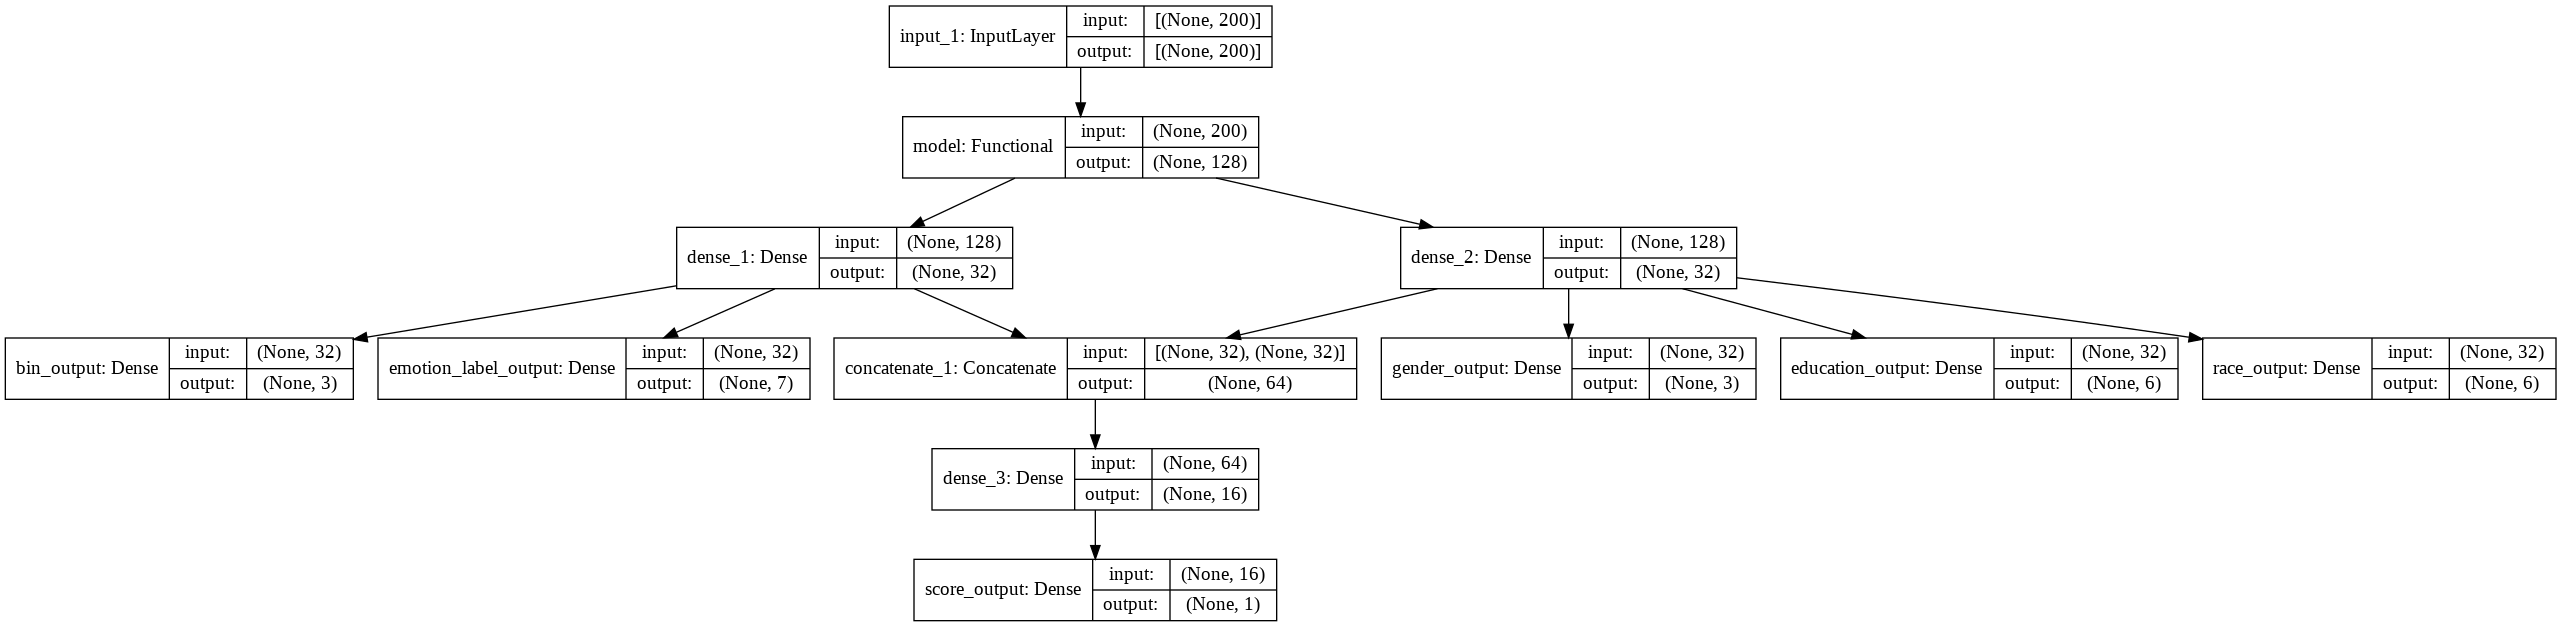

In [ ]:
model_arch = myModel.plot_model_arch()
model_arch

In [ ]:
%%time
histroy = myModel.train(prepared_train_essay,
                        train_outputs, 
                        prepared_val_essay, 
                        val_outputs,
                        epochs=200,
                        batch_size=32)

In [ ]:
%%time
y_pred = myModel.prediction(prepared_val_essay, 
                            model_path="mtlm-emotions-demographic-groups-RoBERTa-epoch-09-val-loss-2.358688.h5")
print(y_pred.shape)

In [ ]:
%%time
corr = myModel.correlation(val_outputs[-1], y_pred)
print("Pearson's Correlation", corr[0])
print("P-value", corr[0])

# For BERT based models

In [51]:
%%time
prepared_train_essay = myModel.prepare_input(utils,
                                             train_essay,
                                             maxlen=200)
print(len(prepared_train_essay))
print(prepared_train_essay[0].shape)

2
(1674, 200)
CPU times: user 1.5 s, sys: 0 ns, total: 1.5 s
Wall time: 1.51 s


In [52]:
%%time
prepared_val_essay = myModel.prepare_input(utils,
                                           val_essay,
                                           maxlen=200)
print(len(prepared_val_essay))
print(prepared_val_essay[0].shape)

2
(186, 200)
CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 165 ms


In [53]:
%%time
train_outputs = myModel.prepare_output(train_data, task="empathy", mode="train")
print(len(train_outputs))
print(train_outputs[0].shape)

val_outputs = myModel.prepare_output(val_data, task="empathy", mode="val")
print(len(val_outputs))
print(val_outputs[0].shape)

6
(1674, 1)
6
(186, 1)
CPU times: user 5.1 ms, sys: 0 ns, total: 5.1 ms
Wall time: 7.03 ms


In [54]:
%%time
myModel.build(np.zeros((1,1)), 
              input_length=200)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
model_10 (Functional)           (None, 128)          125105024   input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 32)           4128        model_10[0][0]            

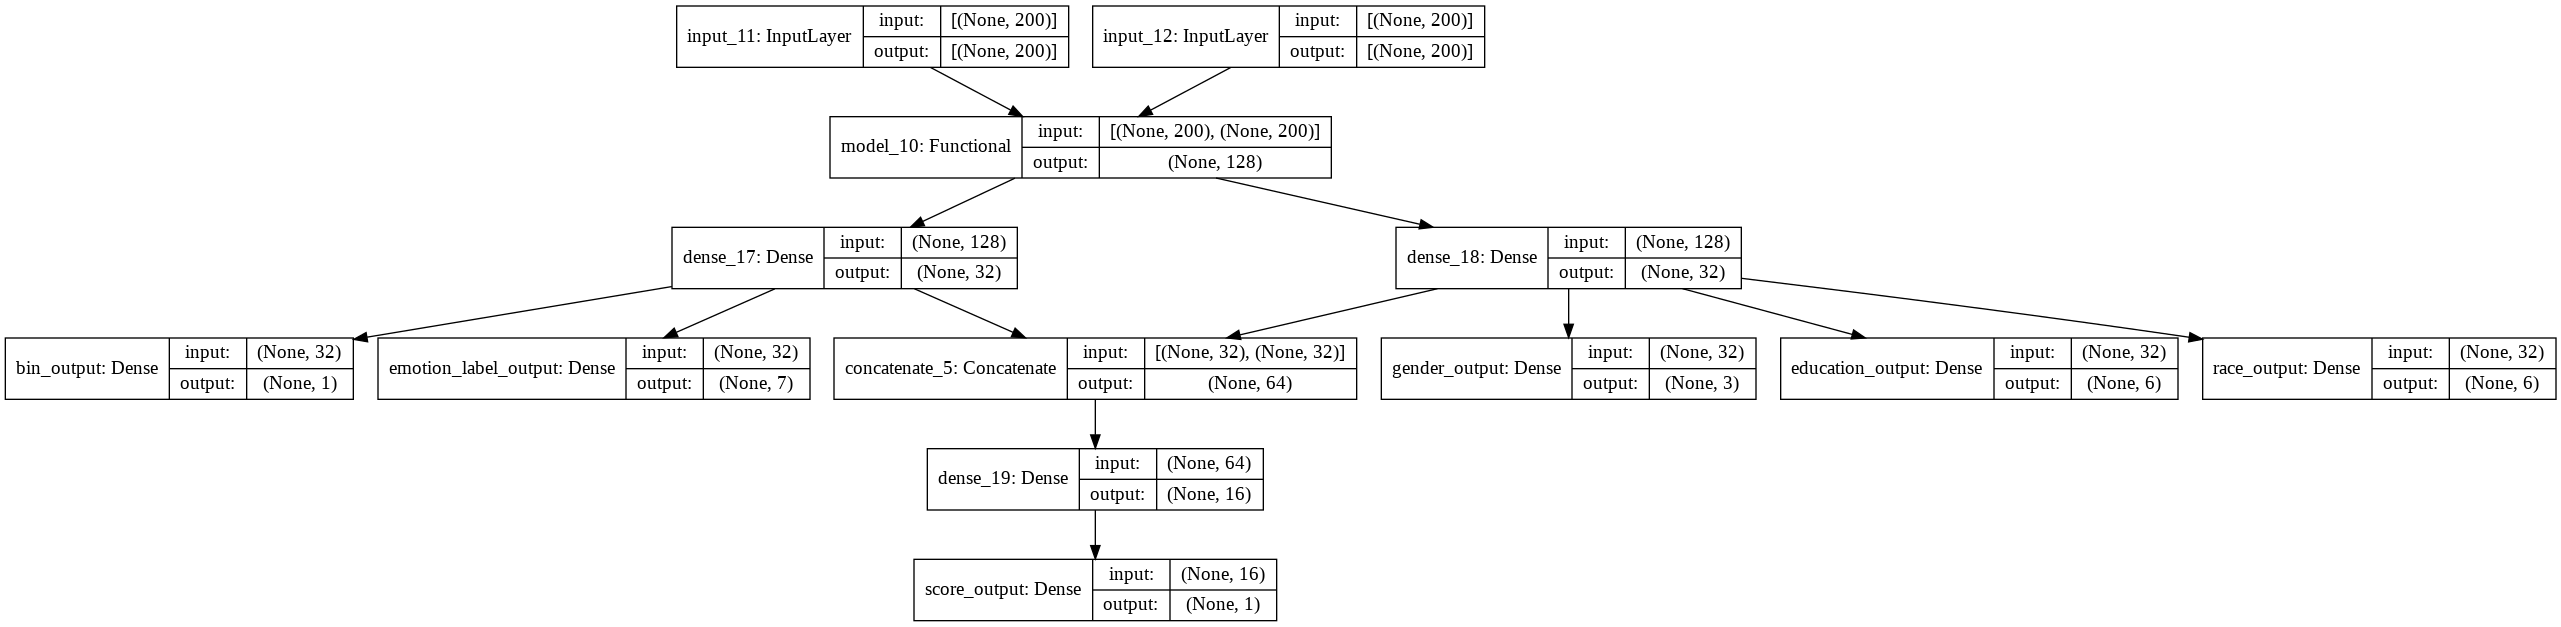

In [55]:
model_arch = myModel.plot_model_arch()
model_arch

In [56]:
%%time
histroy = myModel.train(prepared_train_essay,
                        train_outputs, 
                        prepared_val_essay, 
                        val_outputs,
                        epochs=200,
                        batch_size=32)

Epoch 1/200
53/53 [==============================] - 44s 603ms/step - loss: 12.0341 - bin_output_loss: 0.7349 - emotion_label_output_loss: 2.0689 - gender_output_loss: 0.8920 - education_output_loss: 1.6816 - race_output_loss: 1.3015 - score_output_loss: 4.4094 - val_loss: 9.1502 - val_bin_output_loss: 0.6898 - val_emotion_label_output_loss: 1.8280 - val_gender_output_loss: 0.7281 - val_education_output_loss: 1.4851 - val_race_output_loss: 0.8219 - val_score_output_loss: 2.6976
Epoch 2/200
53/53 [==============================] - 29s 540ms/step - loss: 9.5991 - bin_output_loss: 0.6533 - emotion_label_output_loss: 1.8188 - gender_output_loss: 0.7402 - education_output_loss: 1.4868 - race_output_loss: 0.8717 - score_output_loss: 3.1461 - val_loss: 8.8724 - val_bin_output_loss: 0.6793 - val_emotion_label_output_loss: 1.7722 - val_gender_output_loss: 0.7200 - val_education_output_loss: 1.4867 - val_race_output_loss: 0.8422 - val_score_output_loss: 2.5384
Epoch 3/200
53/53 [================

In [57]:
%%time
y_pred = myModel.prediction(prepared_val_essay, 
                            model_path="mtlm-bin-plus-emotion-demographics-not-cleaned-RoBERTa-tanh-epoch-13-val-loss-2.362103.h5")
print(y_pred.shape)

(186, 1)
CPU times: user 3.14 s, sys: 452 ms, total: 3.59 s
Wall time: 8.09 s


In [58]:
%%time
corr = myModel.correlation(val_outputs[-1], y_pred)
print("Pearson's Correlation", corr[0])
print("P-value", corr[0])

Pearson's Correlation 0.40702111691506637
P-value 0.40702111691506637
CPU times: user 392 µs, sys: 1.12 ms, total: 1.51 ms
Wall time: 2.24 ms
